# Treść zadania

Zbuduj sieć opartą na rekurencyjnych sieciach neuronowych do prognozowania kursu otwarcia akcji (jeden dzień naprzód) .

Dostęp do danych finansowych - biblioteka **yfinance**. 

- Dane uczące:/ walidujące 3 lata (2020-2022) 
  - Podziel dane na ciąg trenujący i walidujący w proporcjach 70:30.
- Oceń jakość modelu 
- Zwizualizuj rzeczywisty i prognozowany kurs otwarcia dla roku 2023
  
Zrealizuj zadanie w wariancie:

- "vanilla RNN" - najprostsza sieć RNN złożona z 20 unitów 
- dwuwarstwowej LSTM, złozonej z 20 unitów.

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torchinfo import summary

In [1]:
# Configuration
TICKER = "AAPL"
START_DATE_TRAIN_VAL = "2020-01-01"
END_DATE_TRAIN_VAL = "2022-12-31"
START_DATE_TEST = "2023-01-01"
END_DATE_TEST = "2023-12-31"
SEQUENCE_LENGTH = 60

## Utils functions

In [9]:
def load_stock_data(ticker, start_date, end_date):
    """
    Loads historical stock data for a given ticker and date range.
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    return data


def preprocess_data(data, scaler, sequence_length, is_train_val=True):
    """
    Preprocesses the data: selects 'Open' price, scales, and creates sequences.
    """
    open_prices = data["Open"].values.reshape(-1, 1)

    if is_train_val:
        scaled_prices = scaler.fit_transform(open_prices)
    else:
        scaled_prices = scaler.transform(open_prices)

    X, y = [], []
    for i in range(sequence_length, len(scaled_prices)):
        X.append(scaled_prices[i - sequence_length : i, 0])
        y.append(scaled_prices[i, 0])

    return np.array(X), np.array(y)

## Load data

In [4]:
print(f"Loading training/validation data for {TICKER}...")
train_val_data = load_stock_data(TICKER, START_DATE_TRAIN_VAL, END_DATE_TRAIN_VAL)
print(f"Loading test data for {TICKER}...")
test_data = load_stock_data(TICKER, START_DATE_TEST, END_DATE_TEST)

Loading training/validation data for AAPL...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Loading test data for AAPL...


[*********************100%***********************]  1 of 1 completed


In [8]:
# Print sample of data
print("Training/validation data:")
print(train_val_data.head())
print(train_val_data.shape)
print("-" * 100)
print("Test data:")
print(test_data.head())
print(test_data.shape)

Training/validation data:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.620827  72.681274  71.373203  71.627077  135480400
2020-01-03  71.914833  72.676462  71.689973  71.847133  146322800
2020-01-06  72.487839  72.526526  70.783241  71.034702  118387200
2020-01-07  72.146950  72.753831  71.926922  72.497537  108872000
2020-01-08  73.307518  73.609752  71.849540  71.849540  132079200
(756, 5)
----------------------------------------------------------------------------------------------------
Test data:
Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2023-01-03  123.470627  129.226068  122.582134  128.614001  112117500
2023-01-04  124.744133  127.014724  123.48050

## Preprocess data

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
# Preprocess training/validation data
X_train_val, y_train_val = preprocess_data(
    train_val_data, scaler, SEQUENCE_LENGTH, is_train_val=True
)
# Split training/validation data
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.3, random_state=42, shuffle=False
)
# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float().unsqueeze(-1)
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(-1)
X_val_tensor = torch.from_numpy(X_val).float().unsqueeze(-1)
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(-1)

print(f"X_train shape: {X_train_tensor.shape}, y_train shape: {y_train_tensor.shape}")
print(f"X_val shape: {X_val_tensor.shape}, y_val shape: {y_val_tensor.shape}")

X_train shape: torch.Size([487, 60, 1]), y_train shape: torch.Size([487, 1])
X_val shape: torch.Size([209, 60, 1]), y_val shape: torch.Size([209, 1])


In [11]:
# Prepare test data
last_sequence_from_train_val = train_val_data["Open"].values[-SEQUENCE_LENGTH:]
combined_open_for_test = np.concatenate(
    (last_sequence_from_train_val, test_data["Open"].values)
)
combined_test_df = pd.DataFrame(combined_open_for_test, columns=["Open"])
scaled_combined_open_for_test = scaler.transform(
    combined_test_df["Open"].values.reshape(-1, 1)
)
X_test, y_test = [], []
for i in range(SEQUENCE_LENGTH, len(scaled_combined_open_for_test)):
    X_test.append(scaled_combined_open_for_test[i - SEQUENCE_LENGTH : i, 0])
    y_test.append(scaled_combined_open_for_test[i, 0])

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test_tensor = torch.from_numpy(X_test).float().unsqueeze(-1)

print(
    f"X_test shape: {X_test_tensor.shape}, y_test (scaled, numpy) shape: {y_test.shape}"
)

X_test shape: torch.Size([250, 60, 1]), y_test (scaled, numpy) shape: (250,)


## Model Definitions

In [12]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [14]:
# Hyperparameters for models
INPUT_SIZE = 1
HIDDEN_SIZE = 20
OUTPUT_SIZE = 1
NUM_RNN_LAYERS = 1
NUM_LSTM_LAYERS = 2

In [25]:
vanilla_rnn_model = VanillaRNN(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_RNN_LAYERS)
lstm_model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LSTM_LAYERS)
print("\nModels instantiated:")
print(summary(vanilla_rnn_model, verbose=0))
print("-" * 100)
print(summary(lstm_model, verbose=0))


Models instantiated:
Layer (type:depth-idx)                   Param #
VanillaRNN                               --
├─RNN: 1-1                               460
├─Linear: 1-2                            21
Total params: 481
Trainable params: 481
Non-trainable params: 0
----------------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Param #
LSTMModel                                --
├─LSTM: 1-1                              5,200
├─Linear: 1-2                            21
Total params: 5,221
Trainable params: 5,221
Non-trainable params: 0


## Training loop

In [26]:
def train_model(
    model,
    criterion,
    optimizer,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    batch_size=64,
):
    """
    Trains the given model and prints training and validation loss.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nTraining on {device}...")
    model.to(device)

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True
    )

    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    val_loader = torch.utils.data.DataLoader(
        dataset=val_dataset, batch_size=batch_size, shuffle=False
    )

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for i, (sequences, labels) in enumerate(train_loader):
            sequences = sequences.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        avg_epoch_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_epoch_train_loss)

        # Validation
        model.eval()
        epoch_val_loss = 0.0
        with torch.inference_mode():
            for sequences, labels in val_loader:
                sequences = sequences.to(device)
                labels = labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item()

        avg_epoch_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_epoch_val_loss)

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_epoch_train_loss:.4f}, Val Loss: {avg_epoch_val_loss:.4f}"
            )

    print("Training complete.")
    return model, train_losses, val_losses

In [27]:
# --- Training Configuration ---
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
BATCH_SIZE = 32

In [28]:
# Train Vanilla RNN Model
print("\n--- Training Vanilla RNN Model ---")
criterion_rnn = nn.MSELoss()
optimizer_rnn = torch.optim.Adam(vanilla_rnn_model.parameters(), lr=LEARNING_RATE)

vanilla_rnn_model, rnn_train_losses, rnn_val_losses = train_model(
    vanilla_rnn_model,
    criterion_rnn,
    optimizer_rnn,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
)


--- Training Vanilla RNN Model ---

Training on cpu...
Epoch [10/50], Train Loss: 0.0015, Val Loss: 0.0020
Epoch [20/50], Train Loss: 0.0010, Val Loss: 0.0015
Epoch [30/50], Train Loss: 0.0008, Val Loss: 0.0018
Epoch [40/50], Train Loss: 0.0009, Val Loss: 0.0015
Epoch [50/50], Train Loss: 0.0008, Val Loss: 0.0013
Training complete.


In [29]:
# Train LSTM Model
print("\n--- Training LSTM Model ---")
criterion_lstm = nn.MSELoss()
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)

lstm_model, lstm_train_losses, lstm_val_losses = train_model(
    lstm_model,
    criterion_lstm,
    optimizer_lstm,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
)


--- Training LSTM Model ---

Training on cpu...
Epoch [10/50], Train Loss: 0.0041, Val Loss: 0.0040
Epoch [20/50], Train Loss: 0.0021, Val Loss: 0.0037
Epoch [30/50], Train Loss: 0.0017, Val Loss: 0.0032
Epoch [40/50], Train Loss: 0.0019, Val Loss: 0.0029
Epoch [50/50], Train Loss: 0.0013, Val Loss: 0.0023
Training complete.


## Prediction, Evaluation, and Visualization

In [33]:
def evaluate_and_plot(
    model,
    model_name,
    X_test_tensor,
    y_test_actual_scaled,
    scaler,
    test_data_full_dates,
    sequence_length,
):
    """
    Makes predictions, evaluates the model, and plots the results.
    """
    if model is None or X_test_tensor is None:
        print(
            f"Skipping evaluation for {model_name} due to missing model or test data."
        )
        return

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    print(f"\n--- Evaluating {model_name} ---")

    with torch.no_grad():
        test_predictions_scaled = model(X_test_tensor.to(device)).cpu().numpy()

    # Inverse transform predictions and actual values
    test_predictions_actual = scaler.inverse_transform(test_predictions_scaled)
    y_test_actual_unscaled = scaler.inverse_transform(
        y_test_actual_scaled.reshape(-1, 1)
    )

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_actual_unscaled, test_predictions_actual))
    print(f"Test RMSE for {model_name}: {rmse:.4f}")

    plt.figure(figsize=(14, 7))
    plt.plot(
        test_data_full_dates.index,
        test_data_full_dates["Open"].values,
        label="Actual Open Price (2023)",
        color="blue",
    )
    plt.plot(
        test_data_full_dates.index,
        test_predictions_actual,
        label=f"Predicted Open Price ({model_name})",
        color="red",
        linestyle="--",
    )

    plt.title(f"{TICKER} Stock Open Price Prediction ({model_name}) - 2023")
    plt.xlabel("Date")
    plt.ylabel("Open Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()


--- Evaluating VanillaRNN ---
Test RMSE for VanillaRNN: 4.3660


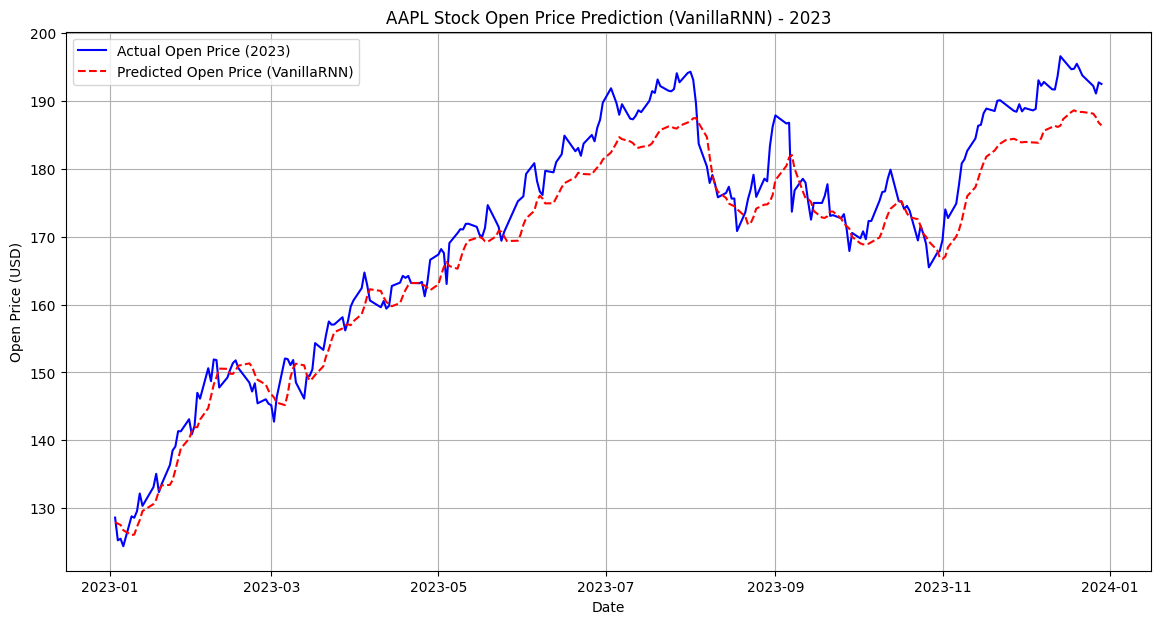

In [34]:
evaluate_and_plot(
    vanilla_rnn_model,
    "VanillaRNN",
    X_test_tensor,
    y_test,
    scaler,
    test_data,
    SEQUENCE_LENGTH,
)


--- Evaluating LSTMModel ---
Test RMSE for LSTMModel: 5.6222


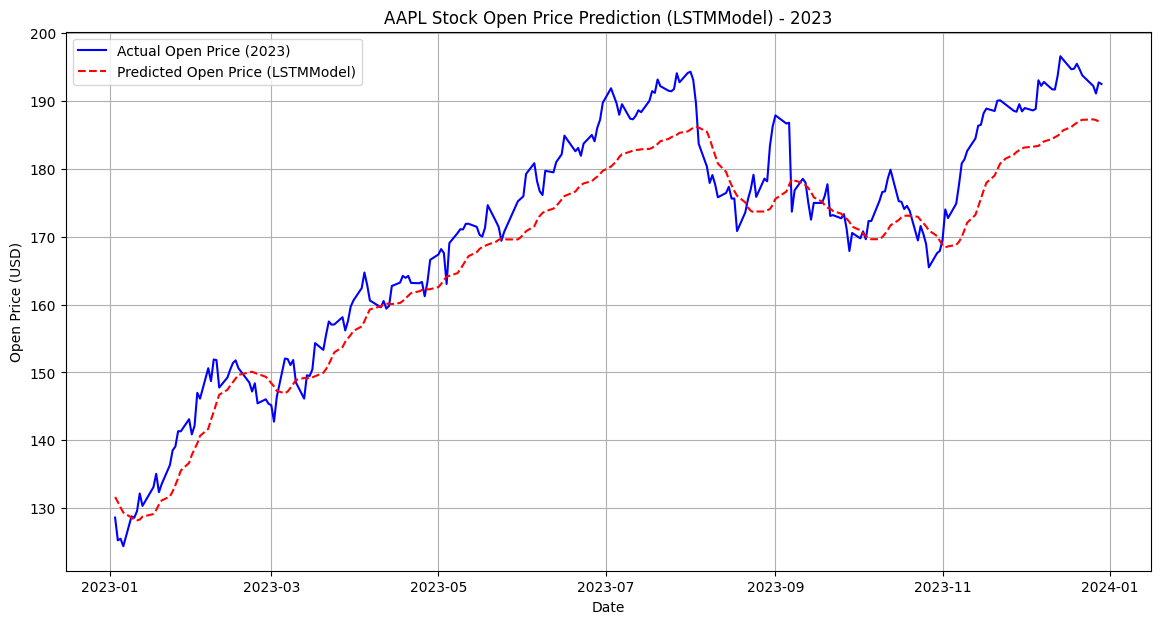

In [35]:
evaluate_and_plot(
    lstm_model, "LSTMModel", X_test_tensor, y_test, scaler, test_data, SEQUENCE_LENGTH
)